In [31]:
%load_ext autoreload

# Enable autoreload for all modules
%autoreload 2

import sys
sys.path.append("..")

import numpy as np
from skimage import measure, morphology
import matplotlib.pyplot as plt

from loader import data_loader
from generator import region_graph_generator

#package to read .png files
from PIL import Image
import os 
from skimage.morphology import skeletonize
from graph_plotting import graph_2D
from loader import vvg_loader
from utils import vvg_tools

from torch_geometric.data import HeteroData
from torch_geometric import transforms
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


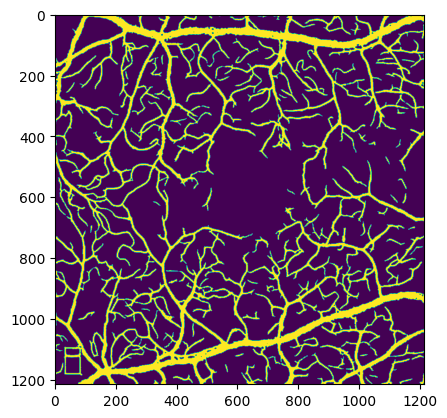

In [22]:
#pred_0235_OD_SCP.png
#pred_0867_OS_SCP.png
seg = Image.open(os.path.join("/media/data/alex_johannes/octa_data/Cairo_examples", "pred_0235_OD_SCP.png"))
seg = np.array(seg)
seg = seg.astype(np.uint8)
plt.imshow(seg)

fail vessel
fail vessel
fail vessel
fail vessel
fail vessel
fail vessel


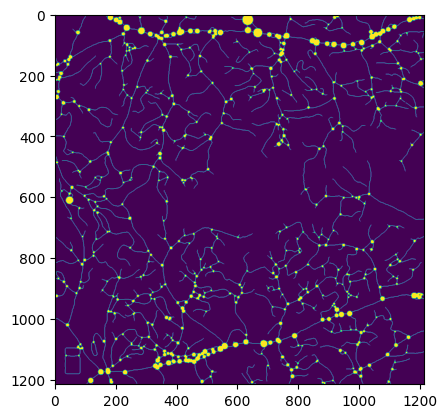

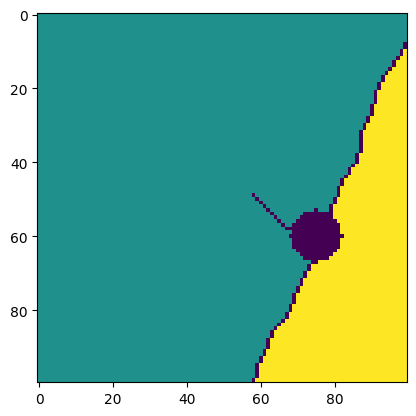

In [23]:
#pred_0235_OD_SCP_graph.json
#pred_0867_OS_SCP_graph.json
vvg_df_edges, vvg_df_nodes = vvg_loader.vvg_to_df(os.path.join("/media/data/alex_johannes/octa_data/Cairo_examples", "pred_0235_OD_SCP_graph.json"))

cl_arr = vvg_tools.vvg_df_to_centerline_array(vvg_df_edges,vvg_df_nodes, seg.shape)


plt.imshow(cl_arr)
plt.show()
seg_labeled = measure.label(cl_arr, background=1, connectivity=1)
plt.imshow(seg_labeled[:100, :100])
plt.show()

In [24]:
seg

array([[  0,   0,   0, ..., 255,   0,   0],
       [  0,   0,   0, ..., 255, 255,   0],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

fail vessel
fail vessel
fail vessel
fail vessel
fail vessel
fail vessel


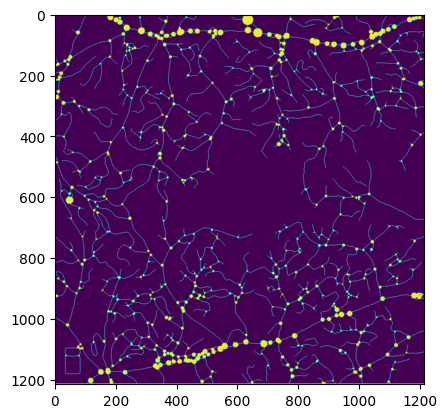

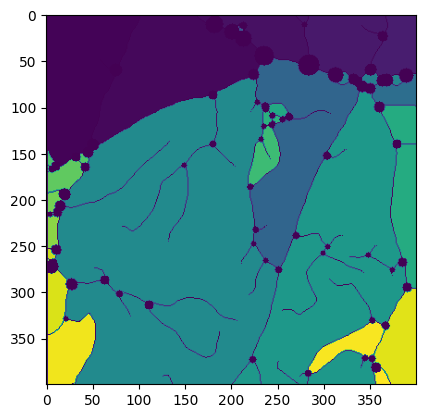

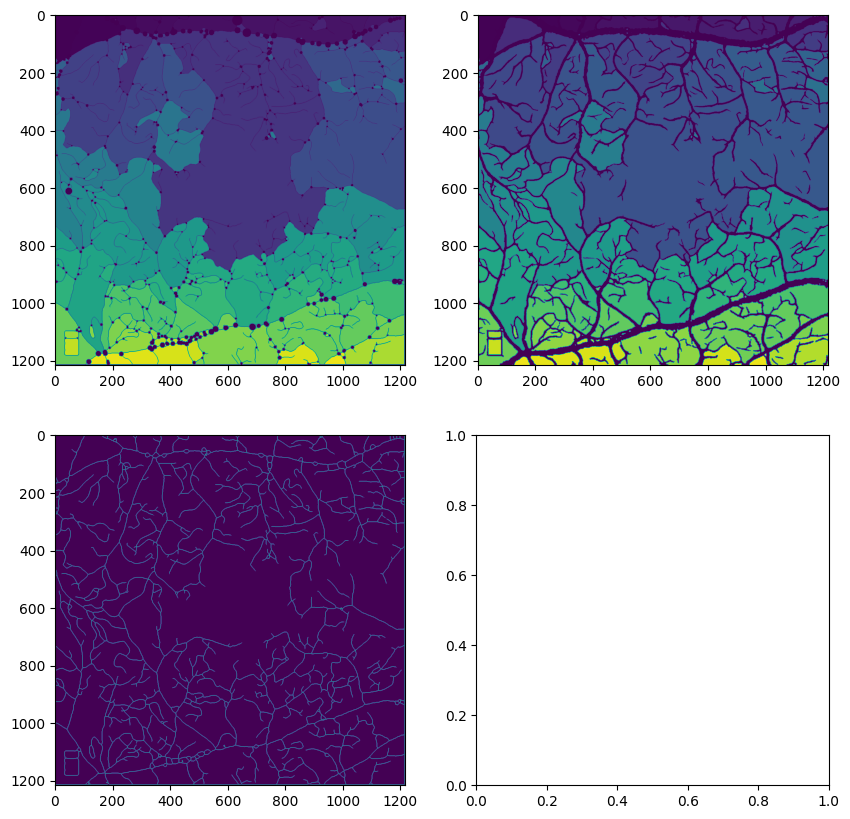

In [25]:
vvg_df_edges, vvg_df_nodes = vvg_loader.vvg_to_df(os.path.join("/media/data/alex_johannes/octa_data/Cairo_examples", "pred_0235_OD_SCP_graph.json"))

cl_arr = vvg_tools.vvg_df_to_centerline_array(vvg_df_edges,vvg_df_nodes, seg.shape)


cl_arr[:2,:] = 1
cl_arr[-2:,:] = 1
cl_arr[:,:2] = 1
cl_arr[:,-2:] = 1

plt.imshow(cl_arr)
plt.show()
seg_labeled = measure.label(cl_arr, background=1, connectivity=1)
plt.imshow(seg_labeled[:400,:400])# seg_labeled[:100, :100])
plt.show()

fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].imshow(seg_labeled)   # seg_labeled[:100, :100])

ax[0,1].imshow(measure.label(seg, background=255))   # seg_labeled[:100, :100])

ax[1,0].imshow(skeletonize(cl_arr))   # seg_labeled[:100, :100])
plt.show()

/home/alex_johannes/octa_gnn/OCTA_gnn/notebooks/../generator/region_graph_generator.py:271: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  region_labels = measure.label(morphology.remove_small_holes(seg, area_threshold=5, connectivity=1).astype("uint8"), background=1)


fail vessel
fail vessel
fail vessel
fail vessel
fail vessel
fail vessel


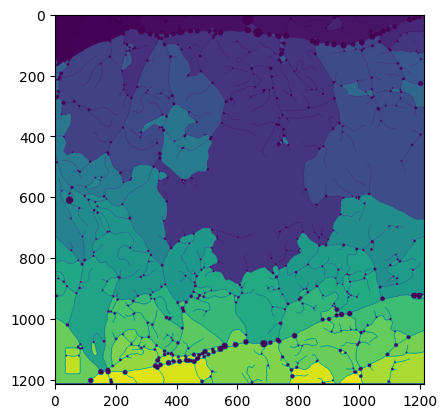

fail vessel
fail vessel
fail vessel
fail vessel
fail vessel
fail vessel
1495
131155 7513
pred_0235_OD_SCP.png
fail vessel
fail vessel


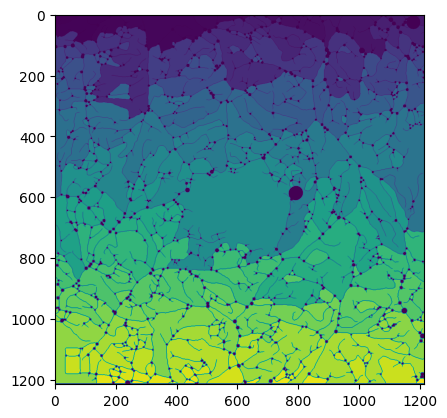

fail vessel
fail vessel
3168
206456 13080
pred_0867_OS_SCP.png


In [95]:
from loader import data_loader


Gernerator_from_VVG = region_graph_generator.VoidGraphFromVVG("/media/data/alex_johannes/octa_data/Cairo_examples", "/media/data/alex_johannes/octa_data/Cairo_examples", "/media/data/alex_johannes/octa_data/Cairo_examples/region_graphs")

Gernerator_from_VVG.save_region_graphs()

In [98]:
loader_region = data_loader.VesselLoaderTorch("/media/data/alex_johannes/octa_data/Cairo_examples/region_graphs", two_cls= True, create_line= False)
loader_vess = data_loader.VesselLoaderTorch("/media/data/alex_johannes/octa_data/Cairo_examples", two_cls= True, create_line= True) # cairo examples contains just the vessel graphs

In [99]:
loader_region.full_data


import pandas as pd
edge_df_ves_reg = pd.read_csv(os.path.join("/media/data/alex_johannes/octa_data/Cairo_examples/hetero_connections", "0235_OD_region_vessel_edges.csv"), sep=";", index_col=0)#"id"
edge_index_ves_reg = torch.tensor(
    edge_df_ves_reg[['node1id', 'node2id']].values, dtype=torch.long).t().contiguous()


def create_hetero_graph(vessel_g, region_g, edge_idx):
    
    het_dat = HeteroData()

    het_dat['void'].x = region_g.x
    het_dat['vessel'].x = vessel_g.x

    het_dat['void'].pos = region_g.pos
    het_dat['vessel'].pos = vessel_g.edge_pos

    het_dat['void', 'to', 'void'].edge_index = region_g.edge_index
    het_dat['vessel', 'to', 'vessel'].edge_index = vessel_g.edge_index

    het_dat['vessel', 'to', 'void'].edge_index = edge_idx
    het_dat = transforms.ToUndirected()(het_dat)
    return het_dat


hetdat =create_hetero_graph(loader_vess.line_data[235], loader_region.full_data[235], edge_index_ves_reg)
hetdat

HeteroData(
  void={
    x=[163, 12],
    pos=[163, 2],
  },
  vessel={
    x=[1145, 17],
    pos=[1145, 2],
  },
  (void, to, void)={ edge_index=[2, 622] },
  (vessel, to, vessel)={ edge_index=[2, 3872] },
  (vessel, to, void)={ edge_index=[2, 1495] },
  (void, rev_to, vessel)={ edge_index=[2, 1495] }
)

In [84]:
for edge in hetdat['vessel', 'to', 'void'].edge_index.T:
    print(edge-1)
    break

tensor([137, 118])


In [107]:
np.unique(hetdat['vessel', 'to', 'void'].edge_index.T[:,1].numpy())
np.unique(hetdat['vessel', 'to', 'void'].edge_index.T[:,0].numpy())

array([   2,    3,    7,    8,    9,   10,   13,   15,   16,   17,   18,
         19,   20,   22,   23,   24,   25,   26,   27,   28,   29,   30,
         31,   32,   33,   34,   35,   36,   37,   38,   39,   40,   41,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   61,   62,   63,   64,   65,   67,
         68,   69,   71,   75,   76,   77,   78,   79,   80,   82,   83,
         84,   85,   86,   87,   88,   89,   90,   91,   92,   93,   94,
         95,   96,   97,   98,   99,  100,  101,  102,  103,  104,  105,
        106,  107,  108,  109,  110,  112,  113,  114,  115,  116,  117,
        118,  119,  120,  121,  122,  123,  124,  125,  126,  127,  128,
        129,  130,  131,  132,  133,  134,  135,  138,  140,  141,  142,
        143,  144,  145,  147,  149,  150,  151,  152,  154,  155,  157,
        159,  160,  161,  162,  163,  164,  165,  166,  167,  168,  169,
        170,  171,  172,  174,  175,  179,  180,  1

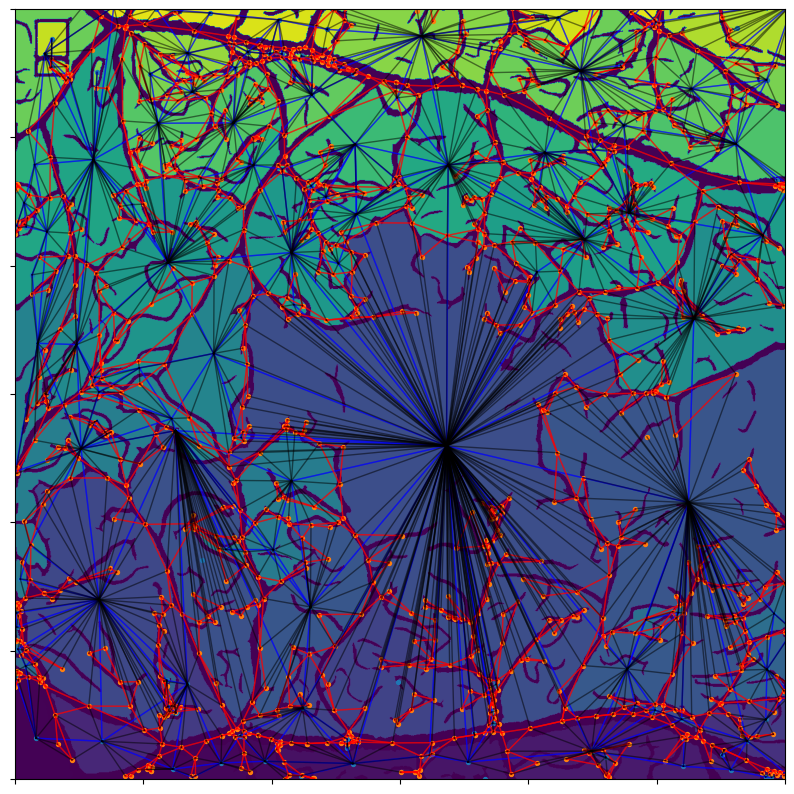

In [123]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(measure.label(seg, background=255, connectivity=1))  
graph_2D.HeteroGraphPlotter2D().plot_graph_2D(hetdat, ax = ax)
plt.show()

In [68]:
loader_vess.line_data[235]

Data(x=[1145, 17], edge_index=[2, 1958], pos=[1009, 2], num_nodes=1145, graph_id=235, edge_pos=[1145, 2])

In [29]:
print(loader_vess.line_data)

{235: Data(x=[1145, 17], edge_index=[2, 1958], pos=[1009, 2], num_nodes=1145, graph_id=235, edge_pos=[1145, 2]), 867: Data(x=[2327, 17], edge_index=[2, 4058], pos=[1999, 2], num_nodes=2327, graph_id=867, edge_pos=[2327, 2])}


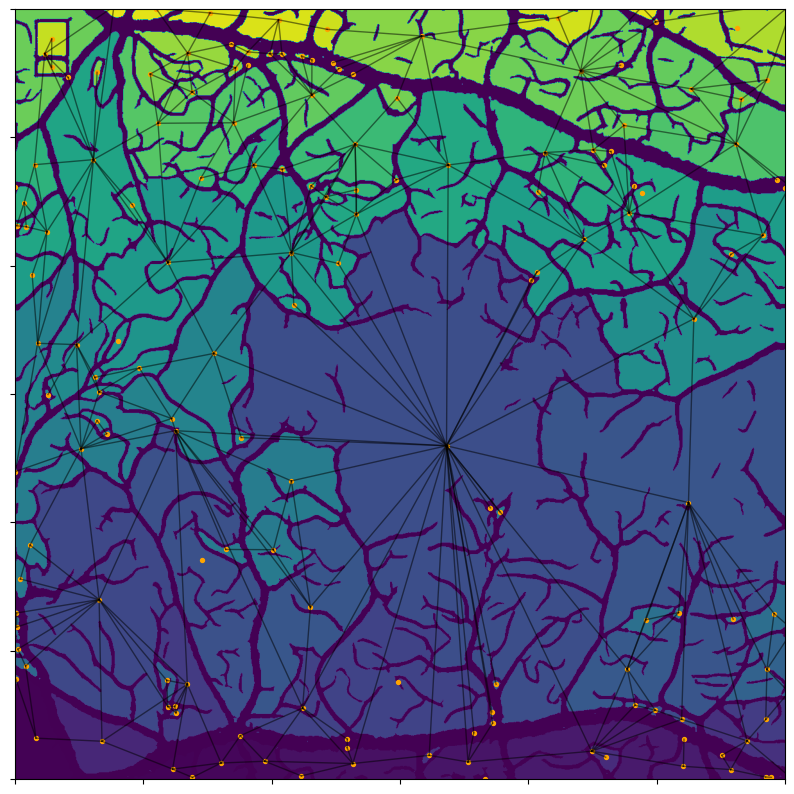

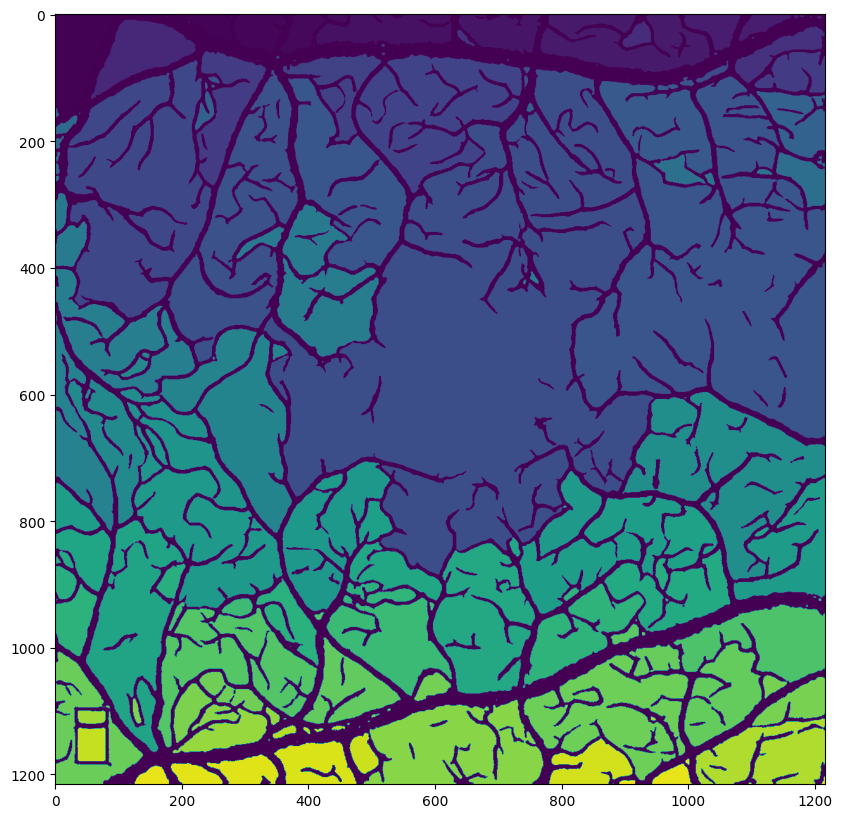

In [126]:
loader_region.full_data[235]

# plot the graph

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(measure.label(seg, background=255, connectivity=1))  
#graph_2D.GraphPlotter2D(loader_region.full_data[235]).plot_graph_2D(edges = True,ax = ax)
graph_2D.GraphPlotter2D(loader_vess.full_data[235]).plot_graph_2D(edges = True,ax = ax)
plt.show()

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(measure.label(seg, background=255, connectivity=1))  
#graph_2D.GraphPlotter2D(loader_region.full_data[235]).plot_graph_2D(edges = True,ax = ax)
graph_2D.GraphPlotter2D(loader_vess.line_data[235],line_G=True).plot_graph_2D(edges = True,ax = ax)
plt.show()